C:\Users\Abid.MD\AppData\Local\Temp\ipykernel_16744\837875411.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Abid.MD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [21:43:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model, scaler, and feature file saved!
Accuracy: 0.794180269694819
ROC-AUC: 0.8451367898938231
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



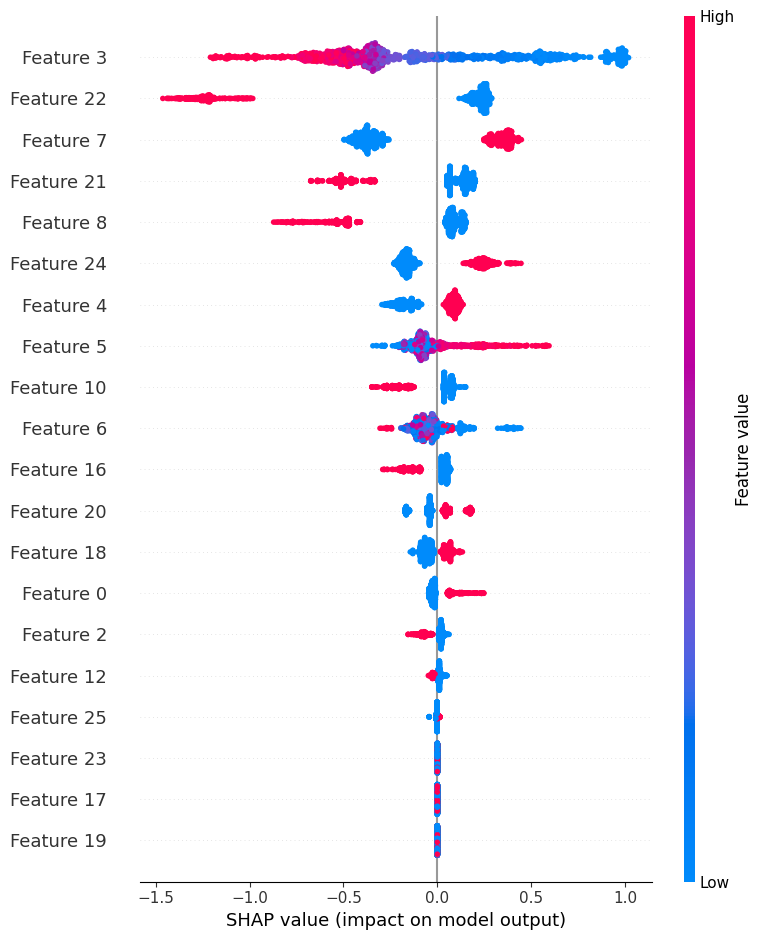

In [1]:
import pandas as pd
import numpy as np
import pickle
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# -----------------------------
# 1. LOAD DATA
# -----------------------------
df = pd.read_csv("churn_data.csv")

df = df.drop("customerID", axis=1)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# -----------------------------
# 2. ENCODING
# -----------------------------
binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
for col in binary_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

multi_cat_cols = df.select_dtypes(include="object").columns.tolist()
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

# -----------------------------
# 3. FEATURE SELECTION (REMOVE WEAK)
# -----------------------------
corr = df.corr(numeric_only=True)["Churn"].abs().sort_values(ascending=False)
weak_features = corr[corr < 0.05].index.tolist()

df = df.drop(columns=weak_features)

X = df.drop("Churn", axis=1)
y = df["Churn"]

# save final feature list
pickle.dump(X.columns.tolist(), open("features.pkl", "wb"))

# -----------------------------
# 4. SPLIT
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 5. SCALE
# -----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pickle.dump(scaler, open("scaler.pkl", "wb"))

# -----------------------------
# 6. TRAIN XGBOOST
# -----------------------------
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
}

search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

# -----------------------------
# 7. SAVE MODEL
# -----------------------------
pickle.dump(best_model, open("model.pkl", "wb"))

print("Model, scaler, and feature file saved!")

# -----------------------------
# 8. EVALUATION
# -----------------------------
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

# SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
